Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import os

Load the dataset

In [2]:
action = pd.read_csv("/Users/yashikasharma/Downloads/Projects/tcs/TCS_stock_action.csv")
history = pd.read_csv("/Users/yashikasharma/Downloads/Projects/tcs/TCS_stock_history.csv")
info = pd.read_csv("/Users/yashikasharma/Downloads/Projects/tcs/TCS_stock_info.csv")
action.head()

,Date,Dividends,Stock Splits
0,2004-10-28,0.3750,0.0
1,2005-02-03,0.4375,0.0
2,2005-07-06,0.6250,0.0
3,2005-08-18,0.3750,0.0
4,2005-10-18,0.3750,0.0


In [3]:
history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [4]:
info.head()

,zip,400001
0,sector,Technology
1,fullTimeEmployees,509058
2,longBusinessSummary,Tata Consultancy Services Limited provides inf...
3,city,Mumbai
4,phone,91 22 6778 9999


In [5]:
history['Date'] = pd.to_datetime(history['Date'])
history.sort_values(by='Date', inplace=True)
history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [6]:
action['Date'] = pd.to_datetime(action['Date'])
action.sort_values(by='Date', inplace=True)
action.head()

,Date,Dividends,Stock Splits
0,2004-10-28,0.3750,0.0
1,2005-02-03,0.4375,0.0
2,2005-07-06,0.6250,0.0
3,2005-08-18,0.3750,0.0
4,2005-10-18,0.3750,0.0


In [7]:
df = history
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


Data Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB


In [9]:
df.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4463,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000
mean,2012-08-23 19:22:31.109119488,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344
min,2002-08-12 00:00:00,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000
25%,2008-02-14 12:00:00,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000
50%,2012-09-04 00:00:00,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000
75%,2017-03-22 12:00:00,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000
max,2021-09-30 00:00:00,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000
std,NaN,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842


In [10]:
# Check for null values
print(df.isnull().sum())

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [11]:
# Convert numeric columns if required
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [12]:
# Fill any remaining NaN values
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Exploratory Data Analysis

In [13]:
corel=df.corr()
corel

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,1.000000,0.899114,0.899354,0.898962,0.899214,-0.177351,0.062321,-0.005701
Open,0.899114,1.000000,0.999888,0.999892,0.999787,-0.153362,0.059743,-0.006715
High,0.899354,0.999888,1.000000,0.999867,0.999914,-0.150918,0.060044,-0.006597
Low,0.898962,0.999892,0.999867,1.000000,0.999901,-0.154962,0.059916,-0.006622
Close,0.899214,0.999787,0.999914,0.999901,1.000000,-0.152844,0.060179,-0.006635
Volume,-0.177351,-0.153362,-0.150918,-0.154962,-0.152844,1.000000,-0.010332,0.004752
Dividends,0.062321,0.059743,0.060044,0.059916,0.060179,-0.010332,1.000000,0.142493
Stock Splits,-0.005701,-0.006715,-0.006597,-0.006622,-0.006635,0.004752,0.142493,1.000000


In [14]:
# Correlation of features with the target variable (Close Price)
correlation_with_close = df.corr()['Close'].sort_values(ascending=False)
print(correlation_with_close)

Close           1.000000
High            0.999914
Low             0.999901
Open            0.999787
Date            0.899214
Dividends       0.060179
Stock Splits   -0.006635
Volume         -0.152844
Name: Close, dtype: float64


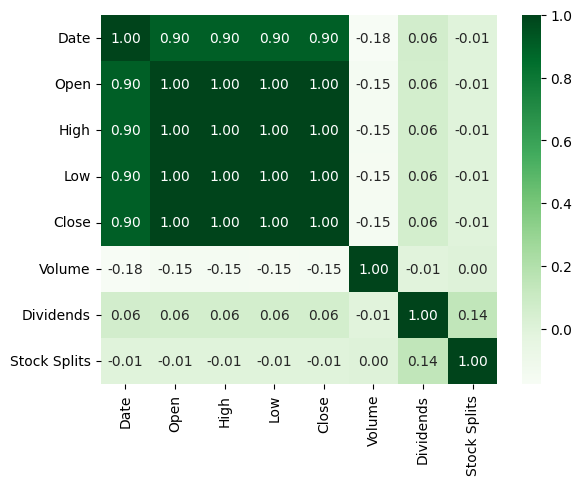

In [15]:
sns.heatmap(corel,annot= True,cmap="Greens",fmt=".2f")
plt.show()

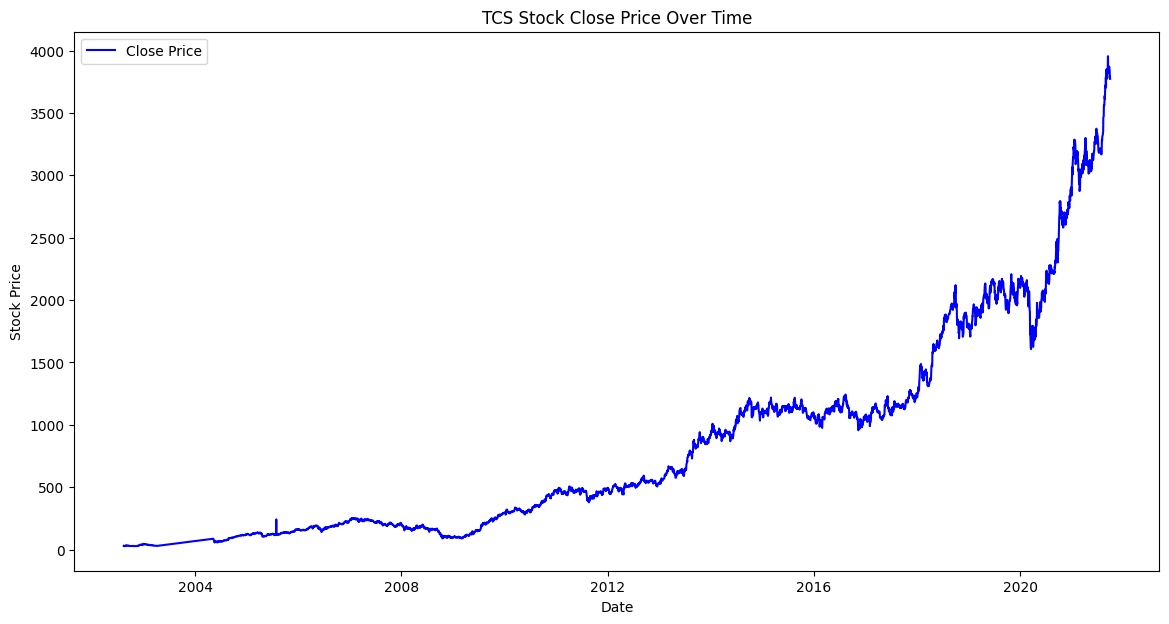

In [16]:
# Plotting Close price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TCS Stock Close Price Over Time')
plt.legend()
plt.show()

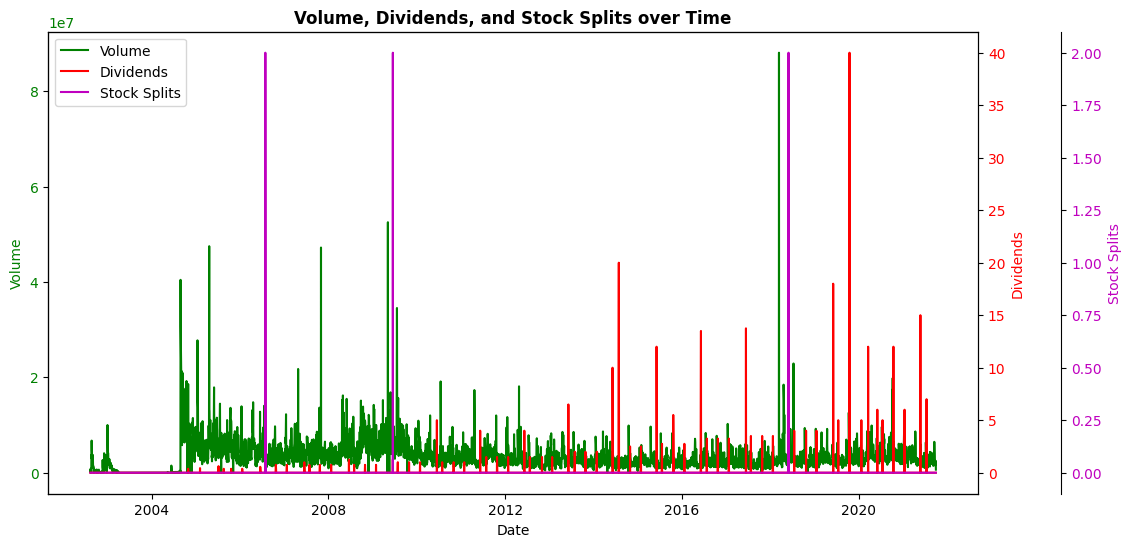

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Volume (left y-axis)
ax1.plot(df['Date'], df['Volume'], color='g', label='Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Second y-axis for Dividends
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Dividends'], color='r', label='Dividends')
ax2.set_ylabel('Dividends', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Third y-axis for Stock Splits
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(df['Date'], df['Stock Splits'], color='m', label='Stock Splits')
ax3.set_ylabel('Stock Splits', color='m')
ax3.tick_params(axis='y', labelcolor='m')

plt.title('Volume, Dividends, and Stock Splits over Time', weight='bold')

# Combined legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')

plt.show()

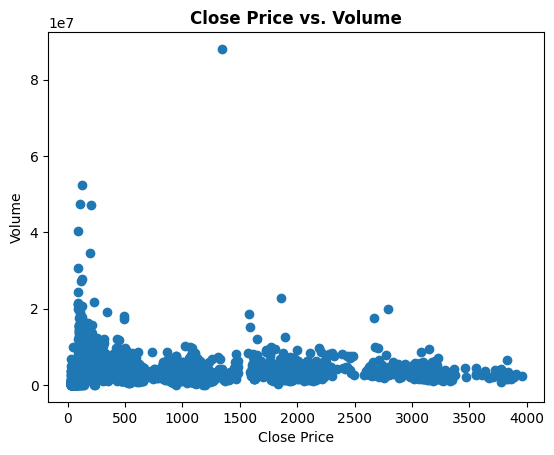

In [18]:
plt.scatter(df['Close'], df['Volume'])
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.title('Close Price vs. Volume', weight="bold")
plt.show()

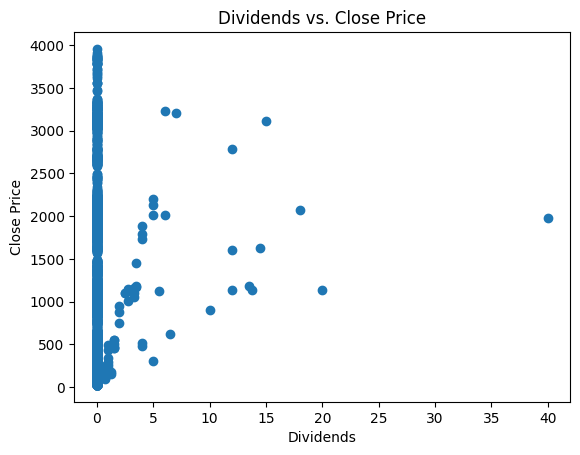

In [19]:
# Dividends vs. Close Price
plt.scatter(df['Dividends'], df['Close'])
plt.xlabel('Dividends')
plt.ylabel('Close Price')
plt.title('Dividends vs. Close Price')
plt.show()

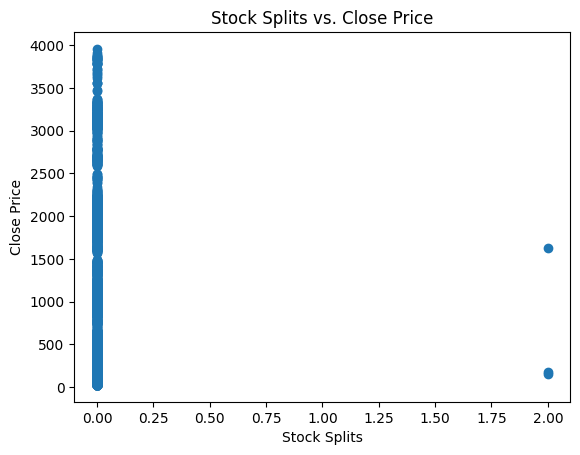

In [20]:
# Stock Splits vs. Close Price
plt.scatter(df['Stock Splits'], df['Close'])
plt.xlabel('Stock Splits')
plt.ylabel('Close Price')
plt.title('Stock Splits vs. Close Price')
plt.show()

In [21]:
# Calculating 50-day and 200-day moving averages
df['MA30']= df['Close'].rolling(window=30).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,MA200
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,NaN
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,NaN
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,NaN
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,NaN


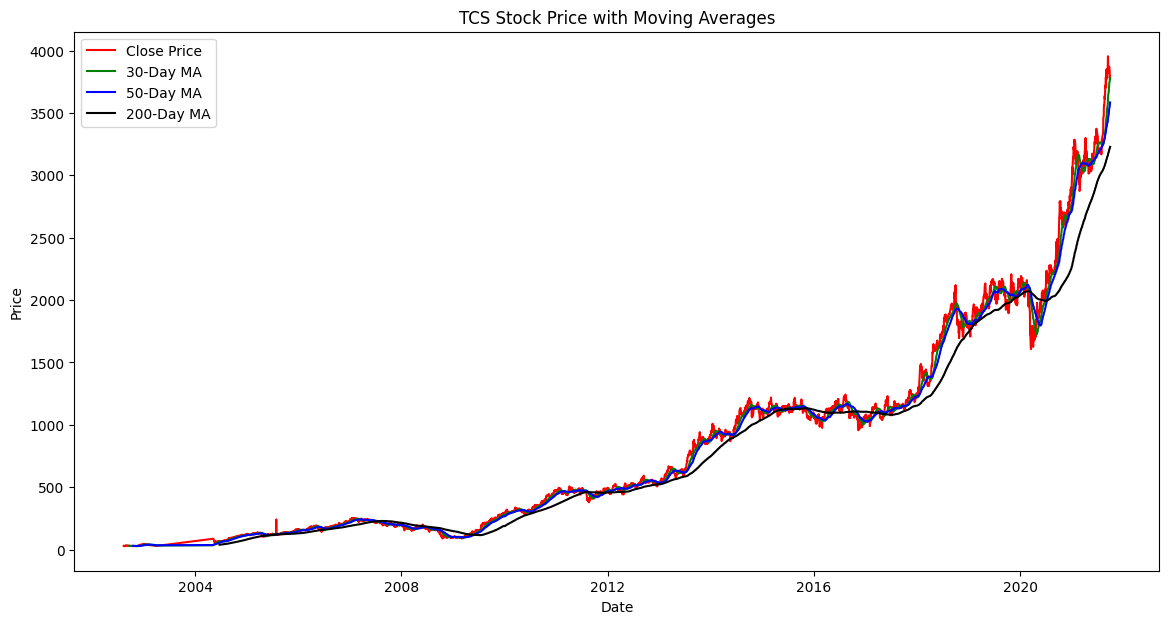

In [22]:
# Plot with Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='r')
plt.plot(df['Date'], df['MA30'], label='30-Day MA', color='g')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', color='b')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', color='k')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TCS Stock Price with Moving Averages')
plt.legend()
plt.show()

In [23]:
df['Short_MA']= df['Close'].rolling(window=5).mean()
df['Long_MA']= df['Close'].rolling(window=30).mean()
# Creating a trading signals based on moving average crossovers
df['Signal']= np.where(df['Short_MA'] > df['Long_MA'], 1,-1)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,MA200,Short_MA,Long_MA,Signal
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,NaN,27.981837,NaN,-1


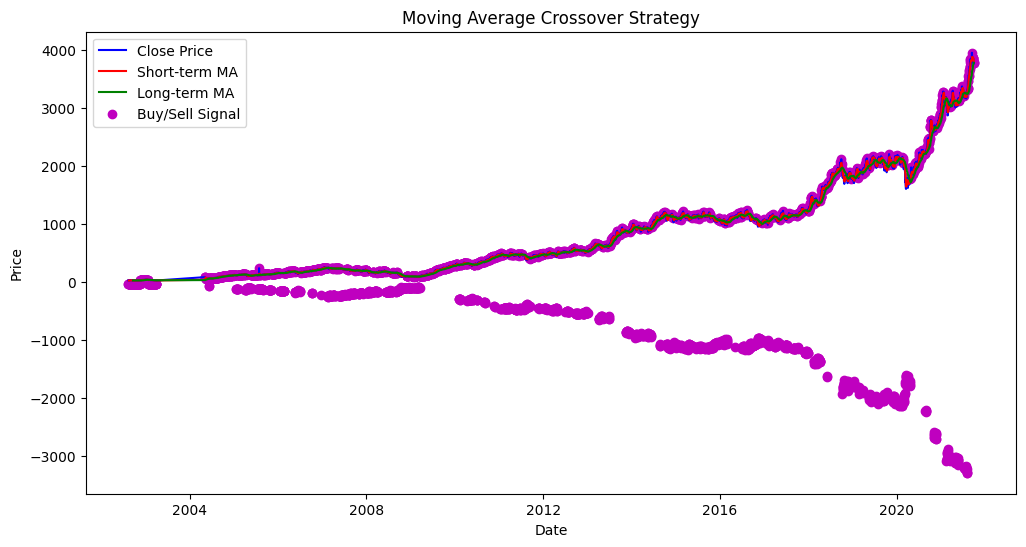

In [24]:
# Plot the strategy signals
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='b')
plt.plot(df['Date'], df['Short_MA'], label='Short-term MA', color='r')
plt.plot(df['Date'], df['Long_MA'], label='Long-term MA', color='g')
plt.scatter(df['Date'], df['Close'] * df['Signal'], label='Buy/Sell Signal', marker='o', color='m')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Average Crossover Strategy')
plt.legend()
plt.show()

In [25]:
df['Daily_Price_Change']= df['Close'].pct_change() * 100
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,MA200,Short_MA,Long_MA,Signal,Daily_Price_Change
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,NaN
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-1.353915
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-6.894351
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,0.000000
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,NaN,27.981837,NaN,-1,-0.239988


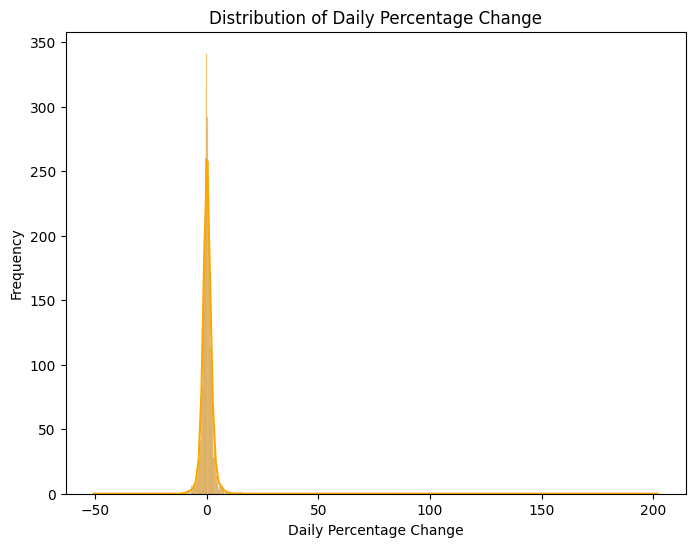

In [26]:
# Distribution of daily percentage change
plt.figure(figsize=(8, 6))
sns.histplot(df['Daily_Price_Change'].dropna(), kde=True, color='orange')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Percentage Change')
plt.show()

Feature Engineering

In [27]:
df['Moving_Avg_Close']= df['Close'].rolling(window=7).mean()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,MA200,Short_MA,Long_MA,Signal,Daily_Price_Change,Moving_Avg_Close
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-1.353915,NaN
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-6.894351,NaN
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,0.000000,NaN
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,NaN,27.981837,NaN,-1,-0.239988,NaN


In [28]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,MA200,Short_MA,Long_MA,Signal,Daily_Price_Change,Moving_Avg_Close,Year,Month,Day,Day_of_Week
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,2002,8,12,0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-1.353915,NaN,2002,8,13,1
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,-6.894351,NaN,2002,8,14,2
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1,0.000000,NaN,2002,8,15,3
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0,NaN,NaN,NaN,27.981837,NaN,-1,-0.239988,NaN,2002,8,16,4


In [29]:
# Lag Features
df['Prev_Close'] = df['Close'].shift(1)
df.dropna(inplace=True) # Drop rows with NaN values from shifting
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA30,MA50,...,Short_MA,Long_MA,Signal,Daily_Price_Change,Moving_Avg_Close,Year,Month,Day,Day_of_Week,Prev_Close
199,2004-06-21,66.919920,68.407029,64.540547,65.451401,49328,0.0,0.0,63.491536,53.539858,...,64.821245,63.491536,1,-1.067759,65.416892,2004,6,21,0,66.157806
200,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,0.0,0.0,63.012254,54.208315,...,64.696706,63.012254,1,-2.328821,64.605620,2004,6,22,1,65.451401
201,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,0.0,0.0,62.661544,54.837176,...,64.456916,62.661544,1,-1.948267,64.387866,2004,6,23,2,63.927155
202,2004-06-24,63.192893,64.317518,61.919554,63.722672,21592,0.0,0.0,62.410594,55.496152,...,64.388143,62.410594,1,1.660755,64.269697,2004,6,24,3,62.681683
203,2004-06-25,63.202185,65.061073,63.202185,63.722672,60280,0.0,0.0,62.327873,56.147134,...,63.901116,62.327873,1,0.000000,64.247132,2004,6,25,4,63.722672


Model Building and Predictions

In [30]:
df.shape

(4264, 21)

In [31]:
# Feature selection
X = df[['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']]
y = df['Close']

In [32]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Predictions
y_pred = model.predict(X_test)

In [35]:
# Evaluation
print("Mean Squared Error:", (y_test, y_pred))
print("R-Squared Score:", mean_squared_error, r2_score(y_test, y_pred))

Mean Squared Error: (4390    3310.525391
2638     943.698853
1985     426.056305
2528     845.380127
2766    1133.698486
           ...     
3910    2057.579590
3928    2103.001953
391      136.090851
1811     465.036804
766      195.313354
Name: Close, Length: 853, dtype: float64, array([3305.40745917,  945.60213005,  422.66452808,  851.1019093 ,
       1129.7701937 , 1805.45191963,  427.09022447,  294.50973062,
        472.00261346,  854.18970713,  448.93651493, 1221.38987995,
        602.89923603,  474.79583167,  249.58320135, 1069.1338193 ,
        195.75235522, 2181.75577391, 1040.37190732, 1804.77235676,
        997.15041454,  122.17458266, 1888.369109  ,  325.61313698,
        480.45455034,  503.95815469,  928.18009243,  548.15034197,
        187.67060232,  191.69673656, 3332.28142507, 3058.35152756,
       1076.81927784,  328.57285973,  531.14007475,  109.47694215,
       1084.75794829, 2726.53196483,  472.54553681, 1869.98773302,
        114.16781782, 1147.26022242, 1129.39457

Data Preparation and Normalisation

In [36]:
# Prepare the data for LSTM
X_train = df['Close'].values.reshape(-1, 1)
y_train = df['Close'].shift(-1).dropna().values

In [37]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_train)

In [38]:
# Define the test data
test_ratio = 0.2
test_size = int(len(df) * test_ratio)
test_data = df[-test_size:]

In [39]:
# Prepare the data for prediction
X_test = test_data['Close'].values.reshape(-1, 1)
X_test_scaled= scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape(-1, 1, 1)

In [40]:
# Reshape the data for LSTM
X_train_lstm = X_train_scaled[:-1].reshape(-1, 1, 1)
y_train_lstm = X_train_scaled[1:]

In [41]:
model= Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# Set the number of epochs and batch size
epochs = 30
batch_size = 15
# Train the model with tqdm progress bar
for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train_lstm), batch_size):
        X_batch= X_train_lstm[i:i+batch_size]
        y_batch= y_train_lstm[i:i+batch_size]
        model.train_on_batch(X_batch, y_batch)
# Prepare the data for prediction
X_test = test_data['Close'].values.reshape(-1, 1)
X_test_scaled= scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape(-1, 1, 1)

100%|██████████| 30/30 [00:05<00:00,  5.50it/s]


In [42]:
lstm_predictions = model.predict(X_test_lstm).flatten()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [43]:
lstm_predictions = lstm_predictions.reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

Visualise Model Performance

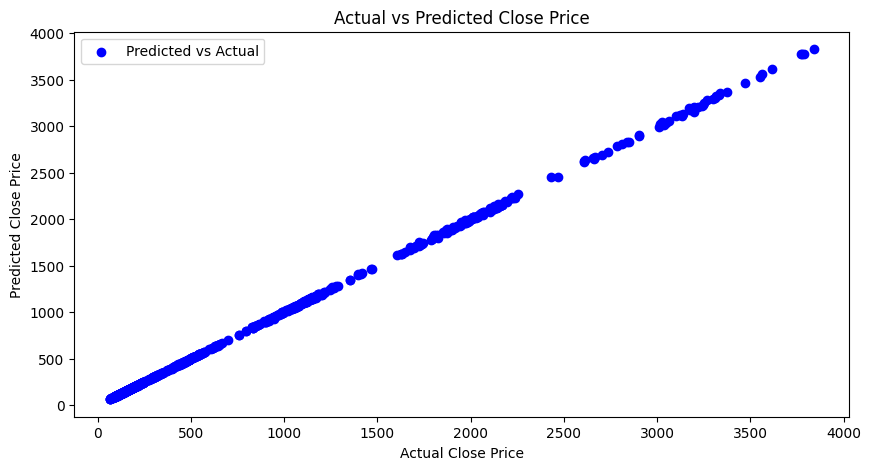

In [44]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

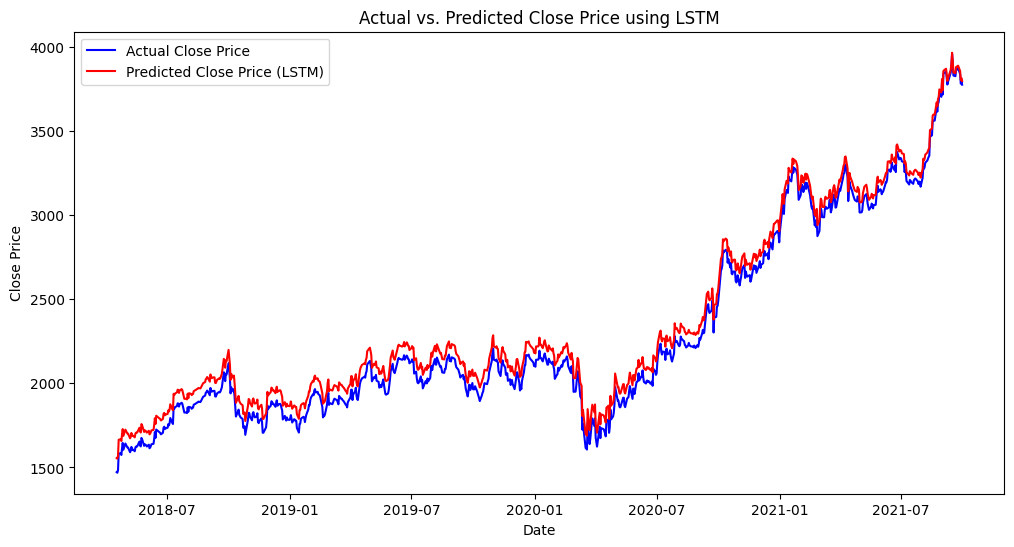

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close Price', color='b')
plt.plot(test_data['Date'], lstm_predictions, label='Predicted Close Price (LSTM)', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price using LSTM')
plt.legend()
plt.show()

In [46]:
lstm_mae = mean_absolute_error(test_data['Close'], lstm_predictions)
print("LSTM Mean Absolute Error:", lstm_mae)

LSTM Mean Absolute Error: 72.50045575782167


Save the model

In [47]:
import pickle
with open('TCS_Stock_Predictor.pkl', 'wb') as file:
    pickle.dump(model, file)

In [48]:
lstm_predictions = lstm_predictions.reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
date_index = test_data.index[-len(lstm_predictions):]
predictions_df= pd.DataFrame({'Date': date_index,
'Predicted_Close': lstm_predictions.flatten()})
predictions_df.to_csv('predictions.csv', index=False)